In [107]:
import pandas as pd
import numpy as np

In [108]:
application = pd.read_csv('../data/application_record.csv')
credit = pd.read_csv('../data/credit_record.csv')

In [109]:
application.info()
application.rename(columns={
    'ID': 'id',
    'CODE_GENDER': 'gender',
    'FLAG_OWN_CAR': 'own_car',
    'FLAG_OWN_REALTY': 'own_estate',
    'CNT_CHILDREN': 'num_children',
    'AMT_INCOME_TOTAL': 'income_total',
    'NAME_INCOME_TYPE': 'income_type',
    'NAME_EDUCATION_TYPE': 'education_type',
    'NAME_FAMILY_STATUS': 'family_status',
    'NAME_HOUSING_TYPE': 'housing_type',
    'DAYS_BIRTH': 'age_days',
    'DAYS_EMPLOYED': 'employed_days',
    'FLAG_MOBIL': 'mobile_flag',
    'FLAG_WORK_PHONE': 'work_phone',
    'FLAG_PHONE': 'phone',
    'FLAG_EMAIL': 'email_flag',
    'OCCUPATION_TYPE': 'occupation',
    'CNT_FAM_MEMBERS': 'num_family_members'
}, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [110]:
credit.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,1048575.0,5.068286e+06,46150.578505,5001711.0,5023644.0,5062104.0,5113856.0,5150487.0
MONTHS_BALANCE,1048575.0,-1.913700e+01,14.023498,-60.0,-29.0,-17.0,-7.0,0.0


In [111]:
credit.rename(columns={'ID':'id', 'MONTHS_BALANCE': 'month'}, inplace=True)

# Vintage Analysis

In [112]:
grouped = credit.groupby('id')
pivot = credit.pivot(index='id', columns='month', values='STATUS')

In [113]:
pivot['open_month'] = grouped.month.min()
pivot['end_month'] = grouped.month.max()
pivot['id'] = pivot.index
pivot = pivot[['id', 'open_month', 'end_month']]
pivot['window'] = pivot.end_month - pivot.open_month
pivot.reset_index(drop=True, inplace=True)
pivot

month,id,open_month,end_month,window
0,5001711,-3,0,3
1,5001712,-18,0,18
2,5001713,-21,0,21
3,5001714,-14,0,14
4,5001715,-59,0,59
...,...,...,...,...
45980,5150482,-28,-11,17
45981,5150483,-17,0,17
45982,5150484,-12,0,12
45983,5150485,-1,0,1


In [114]:
credit = pd.merge(credit, pivot, on='id', how='left')

In [115]:
credit_og = credit.copy()
credit_og['mob'] = credit.month - credit.open_month

credit = credit[credit['window'] > 24]

In [116]:
credit['status'] = np.where((credit.STATUS == '2') |
                        (credit.STATUS == '3') | 
                        (credit.STATUS == '4') |
                        (credit.STATUS == '5'),
                        1, 0)

In [117]:
credit['mob'] = credit.month - credit.open_month
credit.sort_values(by=['id', 'mob'], inplace=True)

In [118]:
denominator = pivot.groupby(['open_month']).agg({'id': ['count']})

<Axes: xlabel='open_month'>

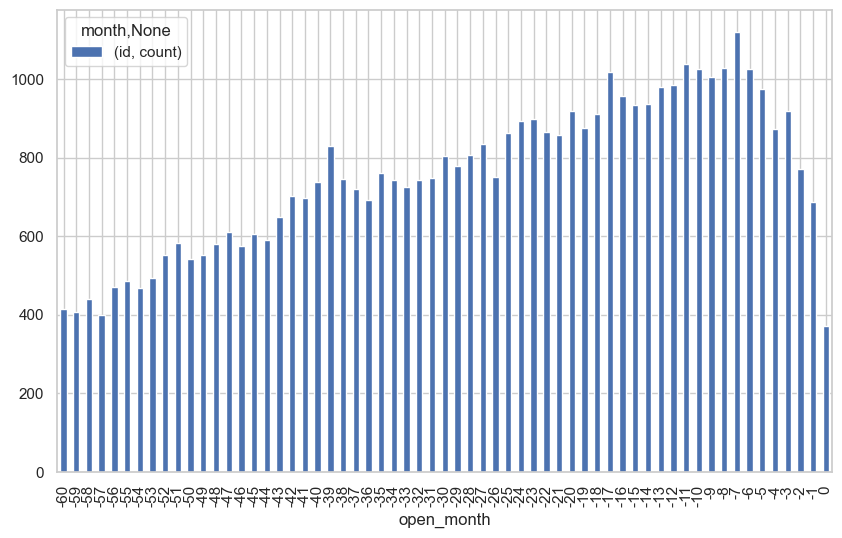

In [119]:
denominator.plot(kind='bar', figsize=(10, 6))

In [120]:
denominator.reset_index(inplace=True)
denominator.columns = ['open_month', 'sum_of_clients']

In [121]:
vintage = credit.groupby(['open_month', 'mob']).agg({'id': ['count']}) 
vintage.reset_index(inplace=True)
vintage.columns = ['open_month', 'mob', 'sum_of_clients'] 

In [122]:
vintage['due_count'] = np.nan
vintage = vintage[['open_month', 'mob', 'due_count']] 

In [123]:
vintage = pd.merge(vintage, denominator, on=['open_month'], how='left')
vintage.head(10)

,open_month,mob,due_count,sum_of_clients
0,-60,0,NaN,415
1,-60,1,NaN,415
2,-60,2,NaN,415
3,-60,3,NaN,415
4,-60,4,NaN,415
5,-60,5,NaN,415
6,-60,6,NaN,415
7,-60,7,NaN,415
8,-60,8,NaN,415
9,-60,9,NaN,415


In [124]:
for j in range(-60, 1):
    overdue_clients = []
    for i in range(0, 61):
        due = list(credit[(credit.status == 1) &
                          (credit.mob == i) &
                          (credit.open_month == j)]['id'])
        overdue_clients.extend(due)
        vintage.loc[(vintage.mob == i) &
                    (vintage.open_month == j), 'due_count'] = len(set(overdue_clients))

In [125]:
vintage['overdue_rate'] = vintage.due_count / vintage.sum_of_clients

In [126]:
vintage_wide = vintage.pivot(index='open_month',
                              columns='mob',
                              values='overdue_rate')
vintage0 = vintage_wide.replace(0, np.nan)


In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\alexe\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alexe\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alexe\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\alexe\AppData\Local\Programs\Python\Python311\Lib\site-p

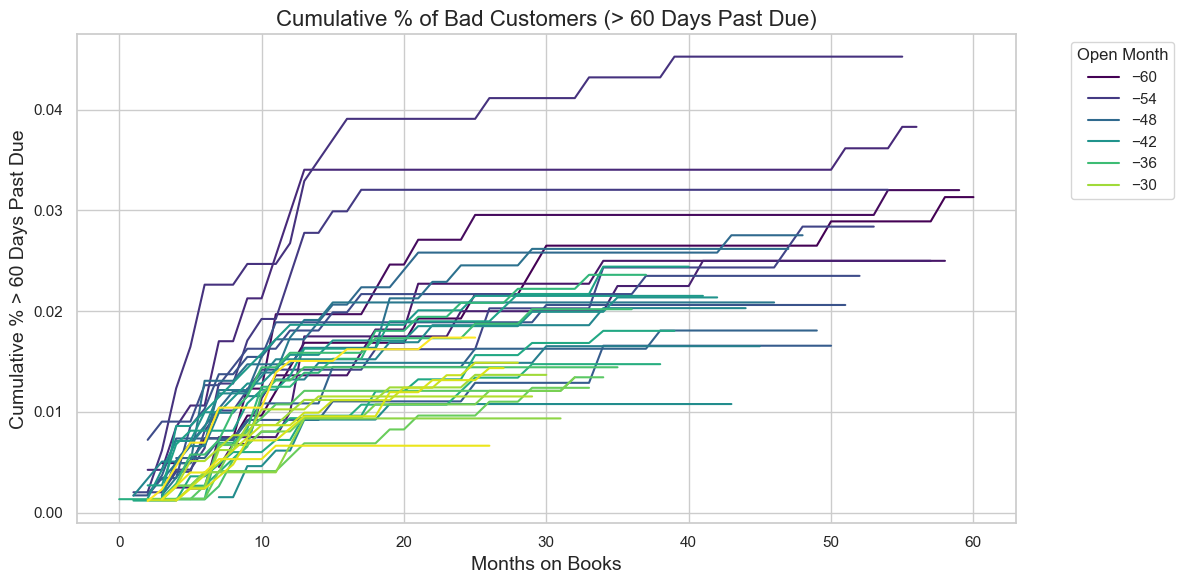

In [128]:
sns.set(style="whitegrid")
# Melt the DataFrame for easier plotting with Seaborn
vintage_melted = vintage0.reset_index().melt(id_vars='open_month', 
                                               var_name='month_on_book', 
                                               value_name='sta_rate')

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=vintage_melted, 
             x='month_on_book', 
             y='sta_rate', 
             hue='open_month', 
             palette='viridis')

# Add titles and labels
plt.title('Cumulative % of Bad Customers (> 60 Days Past Due)', fontsize=16)
plt.xlabel('Months on Books', fontsize=14)
plt.ylabel('Cumulative % > 60 Days Past Due', fontsize=14)
plt.legend(title='Open Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

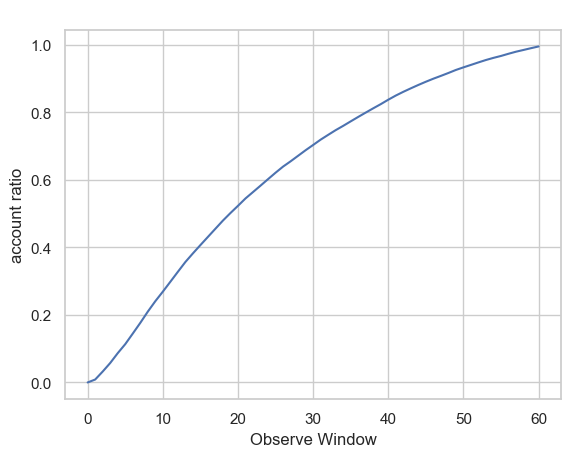

In [129]:
lst = []
for i in range(0,61):
    ratio = len(pivot[pivot['window'] < i]) / len(set(pivot['id']))
    lst.append(ratio)
    
pd.Series(lst).plot(legend = False, grid = True, title = ' ')
plt.xlabel('Observe Window')
plt.ylabel('account ratio')
plt.show()

In [130]:
def calculate_observe(credit, pivot, overdue_statuses):
    '''Calculate observe window based on given overdue statuses.'''
    
    # Count unique IDs
    id_sum = len(set(pivot['id']))
    
    # Initialize status column
    credit['status'] = 0
    
    # Set status to 1 for specified overdue statuses
    credit.loc[credit['STATUS'].isin(overdue_statuses), 'status'] = 1
    
    # Calculate month on book
    credit['mob'] = credit['month'] - credit['open_month']
    
    # Find minimum month on book for overdue accounts
    minagg = credit[credit['status'] == 1].groupby('id')['mob'].min()
    minagg = pd.DataFrame(minagg)
    minagg['id'] = minagg.index
    # Initialize observed list DataFrame
    obslst = pd.DataFrame({'mob': range(0, 61), 'rate': None})
    lst = []
    # Calculate ratios of overdue accounts
    for i in range(0,61):
        due = list(minagg[minagg['mob']  == i]['id'])
        lst.extend(due)
        obslst.loc[obslst['mob'] == i, 'rate'] = len(set(lst)) / id_sum 
    return obslst['rate']

In [131]:
# Define different overdue statuses for analysis
overdue_statuses_1 = ['0', '1', '2', '3', '4', '5']
overdue_statuses_30 = ['1', '2', '3', '4', '5']
overdue_statuses_60 = ['2', '3', '4', '5']
overdue_statuses_90 = ['3', '4', '5']
overdue_statuses_120 = ['4', '5']
overdue_statuses_150 = ['5']

# Define different overdue statuses for analysis
morethan1 = calculate_observe(credit, pivot, overdue_statuses_1)
morethan30 = calculate_observe(credit, pivot, overdue_statuses_30)
morethan60 = calculate_observe(credit, pivot, overdue_statuses_60)
morethan90 = calculate_observe(credit, pivot, overdue_statuses_90)
morethan120 = calculate_observe(credit, pivot, overdue_statuses_120)
morethan150 = calculate_observe(credit, pivot, overdue_statuses_150)

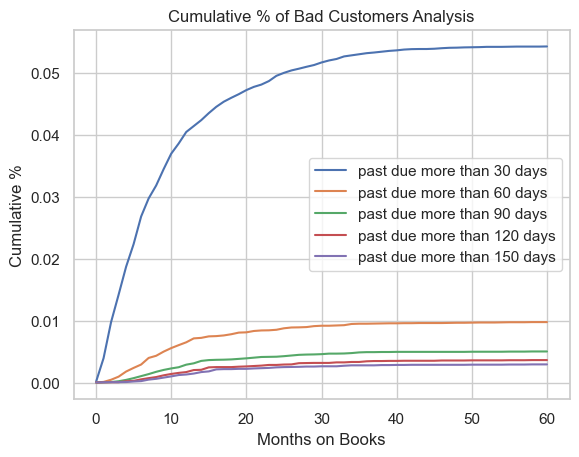

In [132]:
obslst = pd.DataFrame({'past due more than 30 days': morethan30,
                       'past due more than 60 days': morethan60,
                       'past due more than 90 days': morethan90,
                       'past due more than 120 days': morethan120,
                       'past due more than 150 days': morethan150
                        })

obslst.plot(grid = True, title = 'Cumulative % of Bad Customers Analysis')
plt.xlabel('Months on Books')
plt.ylabel('Cumulative %')
plt.show()

In [133]:
def calculate_rate(pivot_tb, credit_og, overdue_statuses):
    '''Calculate bad customer rate based on specified overdue statuses.'''
    
    # Initialize status column
    credit_og['status'] = 0
    
    # Set status to 1 for specified overdue statuses
    credit_og.loc[credit_og['STATUS'].isin(overdue_statuses), 'status'] = 1
    
    # Aggregate the status by ID
    sumagg = credit_og.groupby('id')['status'].agg('sum').reset_index()
    
    # Merge with pivot_tb
    pivot_tb = pd.merge(pivot_tb, sumagg, on='id', how='left')
    
    # Cap status at 1 (indicating bad customers)
    pivot_tb.loc[pivot_tb['status'] > 1, 'status'] = 1
    
    # Calculate the bad customer rate
    rate = pivot_tb['status'].sum() / len(pivot_tb) if len(pivot_tb) > 0 else 0
    
    return round(rate, 4)

In [134]:
# Calculate bad customer ratios
morethan1 = calculate_rate(pivot, credit_og, overdue_statuses_1)
morethan30 = calculate_rate(pivot, credit_og, overdue_statuses_30)
morethan60 = calculate_rate(pivot, credit_og, overdue_statuses_60)
morethan90 = calculate_rate(pivot, credit_og, overdue_statuses_90)
morethan120 = calculate_rate(pivot, credit_og, overdue_statuses_120)
morethan150 = calculate_rate(pivot, credit_og, overdue_statuses_150)

# Create summary DataFrame
summary_dt = pd.DataFrame({
    'situation': [
        'past due more than 1 day',
        'past due more than 30 days',
        'past due more than 60 days',
        'past due more than 90 days',
        'past due more than 120 days',
        'past due more than 150 days'
    ],
    'bad customer ratio': [
        morethan1,
        morethan30,
        morethan60,
        morethan90,
        morethan120,
        morethan150
    ]
})

summary_dt

,situation,bad customer ratio
0,past due more than 1 day,0.8705
1,past due more than 30 days,0.1163
2,past due more than 60 days,0.0145
3,past due more than 90 days,0.0072
4,past due more than 120 days,0.0053
5,past due more than 150 days,0.0042


<Axes: ylabel='Frequency'>

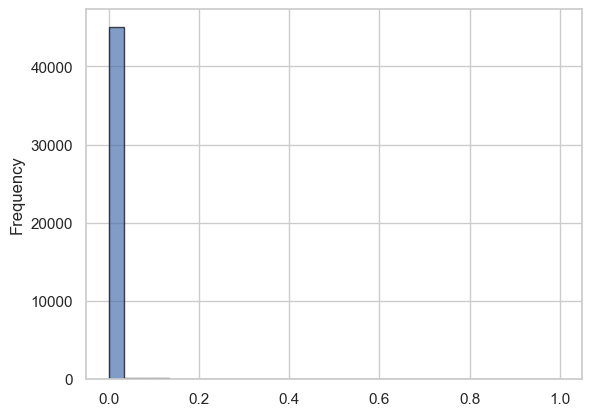

In [135]:
def calculate_overdue_rate_per_id(credit):
    # Ensure that 'status' is 1 for overdue and 0 otherwise
    credit['status'] = np.where(
        credit['STATUS'].isin(['2', '3', '4', '5']), 1, 0
    )
    
    # Group by 'id' and 'mob' to sum overdue counts for each 'id'
    id_overdue_counts = credit.groupby('id')['status'].sum().reset_index()
    
    # Rename columns for clarity
    id_overdue_counts.columns = ['id', 'overdue_count']
    
    # Calculate the total number of months on book for each 'id'
    total_months = credit.groupby('id')['mob'].max().reset_index()
    total_months.columns = ['id', 'total_months_on_book']
    
    # Merge the overdue counts with the total months on book for each 'id'
    overdue_rate_df = pd.merge(id_overdue_counts, total_months, on='id')
    
    # Calculate the overdue rate for each 'id' (overdue count / total months)
    overdue_rate_df['overdue_rate'] = (
        overdue_rate_df['overdue_count'] / overdue_rate_df['total_months_on_book']
    )
    
    return overdue_rate_df

# Calculate the overdue rate for each 'id'
overdue_rate_per_id = calculate_overdue_rate_per_id(credit_og)

# Display the result
overdue_rate_per_id.overdue_rate.plot(kind='hist', bins=30, edgecolor='black', alpha=0.7)

In [136]:
def assign_labels_based_on_rate(overdue_rate_df, threshold=0.0145):
    """
    Assign labels to customers based on their overdue rate.
    
    Parameters:
    overdue_rate_df (DataFrame): DataFrame containing 'id' and 'overdue_rate'.
    threshold (float): The threshold for labeling bad customers.
    
    Returns:
    DataFrame: Updated DataFrame with 'label' column indicating bad customers.
    """
    # Assign labels: 1 for bad customers, 0 for good customers
    overdue_rate_df['label'] = np.where(overdue_rate_df['overdue_rate'] >= threshold, 1, 0)
    
    return overdue_rate_df

# Assign labels based on an overdue rate threshold (e.g., 50%)
overdue_rate_labeled = assign_labels_based_on_rate(overdue_rate_per_id)

# Display the result
value_counts = overdue_rate_labeled.label.value_counts()
percentages = (value_counts / value_counts.sum()) * 100
percentages

label
0    98.549527
1     1.450473
Name: count, dtype: float64

In [137]:
value_counts = credit_og['status'].value_counts()
percentages = (value_counts / value_counts.sum()) * 100
percentages


status
0    99.703979
1     0.296021
Name: count, dtype: float64

In [138]:
# Merge overdue_rate_labeled with application based on 'id'
labeled_application = pd.merge(application, overdue_rate_labeled[['id', 'label']], on='id', how='left')

# Assign 'new' for missing IDs in the credit dataset
labeled_application['label'].fillna('new', inplace=True)

# Now assign the same in the credit dataset
credit_labeled = pd.merge(credit_og, overdue_rate_labeled[['id', 'label']], on='id', how='left')
credit_labeled['label'].fillna('new', inplace=True)

# Show the updated datasets
print(labeled_application[['id', 'label']].head())
print(credit_labeled[['id', 'label']].head())

        id label
0  5008804   0.0
1  5008805   0.0
2  5008806   0.0
3  5008808   0.0
4  5008809   0.0
        id  label
0  5001711      0
1  5001711      0
2  5001711      0
3  5001711      0
4  5001712      0


C:\Users\alexe\AppData\Local\Temp\ipykernel_25196\811519715.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  labeled_application['label'].fillna('new', inplace=True)
C:\Users\alexe\AppData\Local\Temp\ipykernel_25196\811519715.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'new' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  labeled_application['label'].fillna('new', inplace=True)
C:\Users\alexe\

In [139]:
value_counts = credit_labeled[credit_labeled['label'] != 'new']['label'].value_counts()
percentages = (value_counts / value_counts.sum()) * 100
percentages

label
0    97.808359
1     2.191641
Name: count, dtype: float64

In [140]:
value_counts = labeled_application[labeled_application['label'] != 'new']['label'].value_counts()
percentages = (value_counts / value_counts.sum()) * 100
percentages 

label
0.0    98.310338
1.0     1.689662
Name: count, dtype: float64

In [141]:
labeled_application.to_csv('../data/labeled_application.csv', index=False)
credit_labeled.to_csv('../data/labeled_credit.csv', index=False)

In [143]:
credit_labeled.shape

(1048575, 9)

# Survival Analysis

In [144]:
from lifelines import KaplanMeierFitter

In [145]:
# Group customers by ID and identify if they have become overdue (status == 1)
credit['truncate'] = credit.groupby('id')['status'].transform('max')

# Separate customers who have become overdue and those who haven't
truncate = credit[credit['truncate'] == 1]
not_trunc = credit[credit['truncate'] == 0]

# For customers who have not gone overdue, take the maximum 'month_on_book'
dt1 = not_trunc.groupby('id').agg(
    month_on_book=('mob', 'max'),
    truncate=('truncate', 'max')
).reset_index()

# For customers who have gone overdue, take the minimum 'month_on_book' where status == 1
dt2 = truncate[truncate['status'] == 1].groupby('id').agg(
    month_on_book=('mob', 'min'),
    truncate=('truncate', 'max')
).reset_index()

# Combine the two datasets (overdue and non-overdue customers)
dt = pd.concat([dt1, dt2])

# Display the result
print(dt.head())

        id  month_on_book  truncate
0  5001715             59         0
1  5001718             38         0
2  5001719             42         0
3  5001720             35         0
4  5001723             30         0


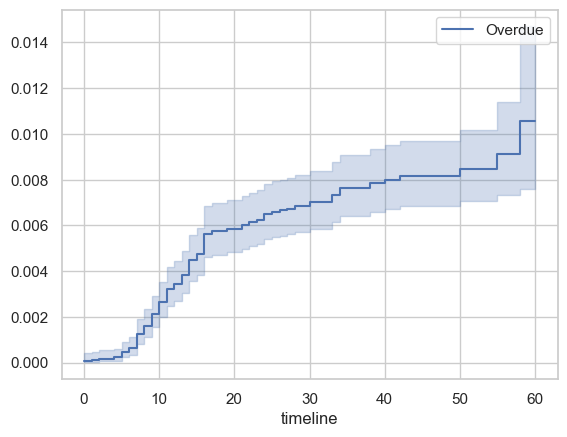

In [146]:
# Fit the Kaplan-Meier Fitter model
kmf = KaplanMeierFitter()
kmf.fit(dt['month_on_book'], event_observed=dt['truncate'], label='Overdue')

# Calculate key outputs
median_survival = kmf.median_survival_time_
survival_at_10 = kmf.survival_function_at_times([10]).values[0]
cumulative_hazard = kmf.plot_cumulative_density()

# Create a DataFrame to store the key results
key_outputs = pd.DataFrame({
    "Key Output": ["Survival Function at Month 10", "Median Survival Time", "Cumulative Hazard Plot"],
    "Value": [f"S(10) = {survival_at_10:.2f} (80% customers not overdue by month 10)",
              f"{median_survival} months",
              "See Plot Below"]
})

<Axes: xlabel='timeline'>

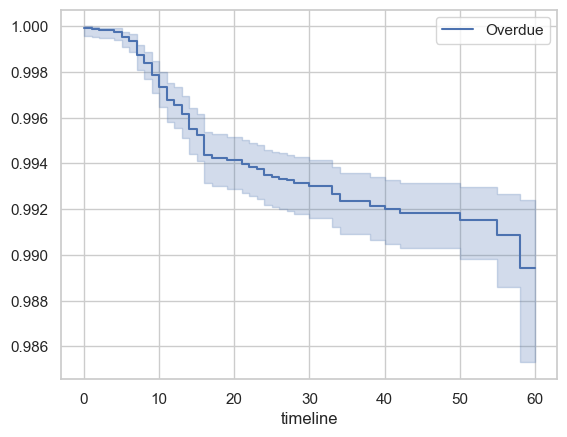

In [147]:
kmf.plot()


In [148]:
application.CODE_GENDER.value_counts()

AttributeError: 'DataFrame' object has no attribute 'CODE_GENDER'

In [65]:
yn_cat_features = ['own_car', 'own_estate']

application_survival_features = ['gender', 'own_car', 'own_estate', 'num_children',
                            'income_type', 'education_type', 'family_status',
                            'housing_type', 'mobile_flag', 'work_phone',
                            'phone', 'email_flag', 'occupation', 'num_family_members']

application_cat_features_id = ['id', 'gender', 'own_car', 'own_estate', 'num_children',
                            'income_type', 'education_type', 'family_status',
                            'housing_type', 'mobile_flag', 'work_phone',
                            'phone', 'email_flag', 'occupation', 'num_family_members']


In [66]:
for feature in application_survival_features:
    print(f"Value counts for '{feature}':")
    print(application[feature].value_counts())
    print("\n" + "-"*50 + "\n")

Value counts for 'gender':
gender
F    294440
M    144117
Name: count, dtype: int64

--------------------------------------------------

Value counts for 'own_car':
own_car
N    275459
Y    163098
Name: count, dtype: int64

--------------------------------------------------

Value counts for 'own_estate':
own_estate
Y    304074
N    134483
Name: count, dtype: int64

--------------------------------------------------

Value counts for 'num_children':
num_children
0     304071
1      88527
2      39884
3       5430
4        486
5        133
7          9
9          5
12         4
6          4
14         3
19         1
Name: count, dtype: int64

--------------------------------------------------

Value counts for 'income_type':
income_type
Working                 226104
Commercial associate    100757
Pensioner                75493
State servant            36186
Student                     17
Name: count, dtype: int64

--------------------------------------------------

Value counts for 'ed

In [67]:
def plot_km(dt, timevar, truncate, groupby):
    '''plot km by subgroup for categorical features'''
    plt.rcParams['figure.facecolor'] = 'white'
    kmf = KaplanMeierFitter()
    t = np.linspace(0, 60, 61)  # timeline up to 60 months
    for i in dt[groupby].value_counts().index:
        kmf.fit(dt[dt[groupby] == i][timevar], event_observed=dt[dt[groupby] == i][truncate], timeline=t, label=str(i))
        kmf.plot()
    plt.title(f"Kaplan-Meier Curve by {groupby}")
    plt.xlabel('Time (Months)')
    plt.ylabel('Survival Probability')
    plt.legend(title=groupby)
    plt.show()

In [68]:
application_cat = application[application_cat_features_id]
dt = pd.merge(dt, application, on = 'id', how = 'left')
dt.fillna('unknown',inplace=True)

C:\Users\alexe\AppData\Local\Temp\ipykernel_18808\3442565865.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dt.fillna('unknown',inplace=True)


Plotting KM curve for: gender


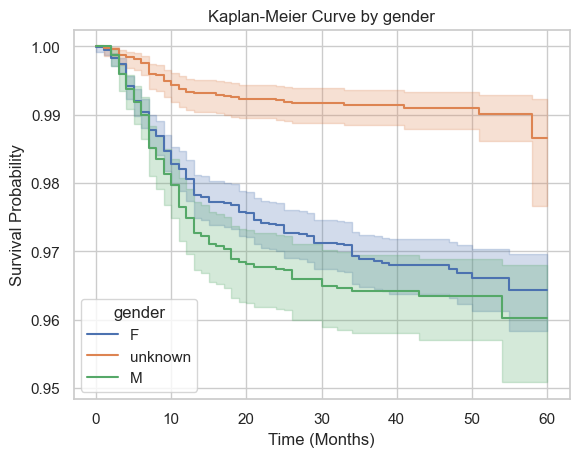

Plotting KM curve for: own_car


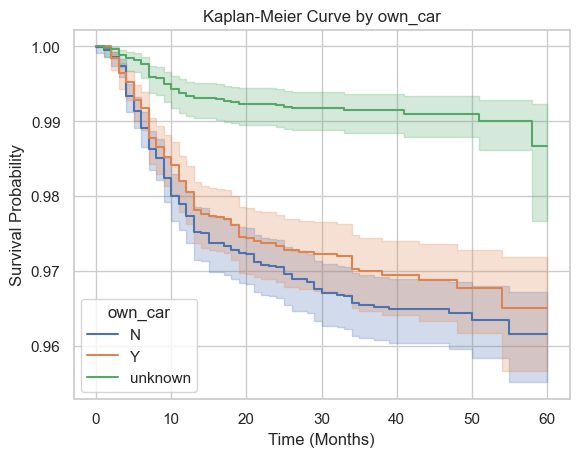

Plotting KM curve for: own_estate


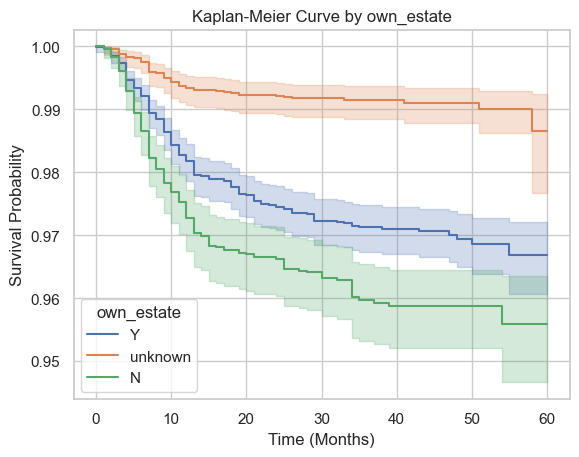

Plotting KM curve for: num_children


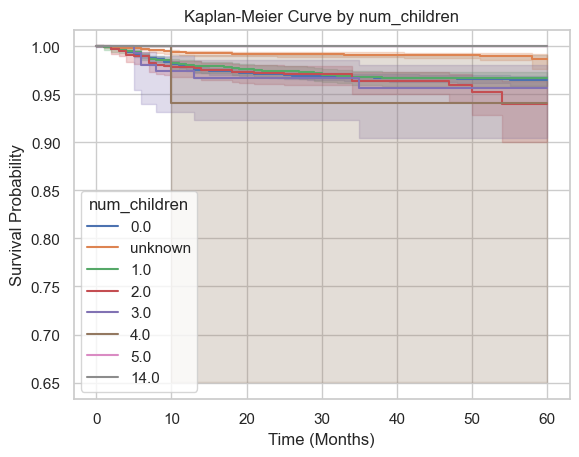

Plotting KM curve for: income_type


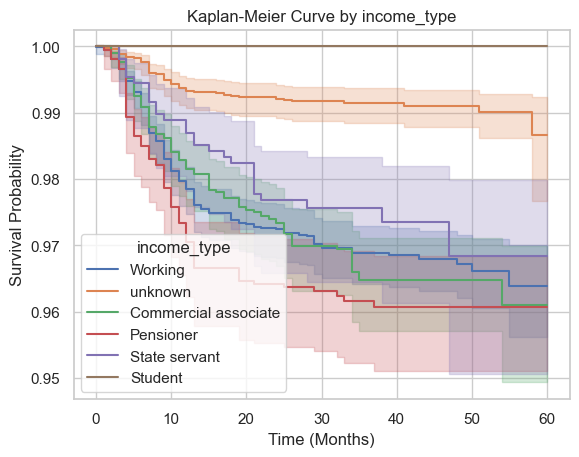

Plotting KM curve for: education_type


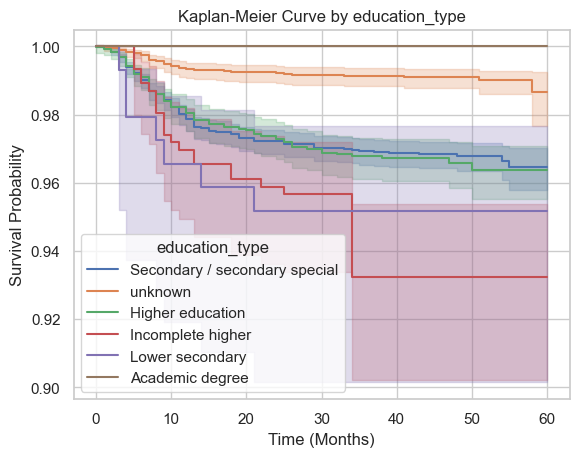

Plotting KM curve for: family_status


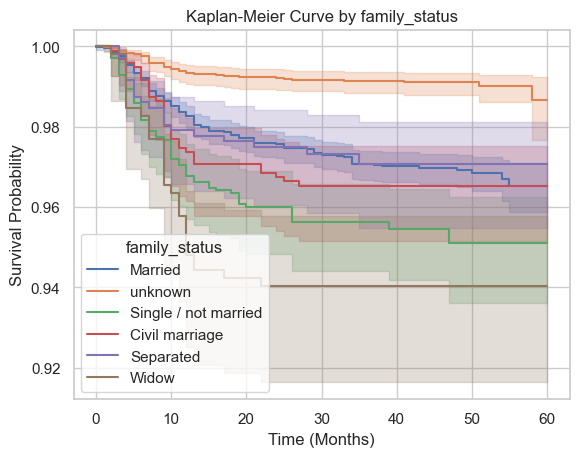

Plotting KM curve for: housing_type


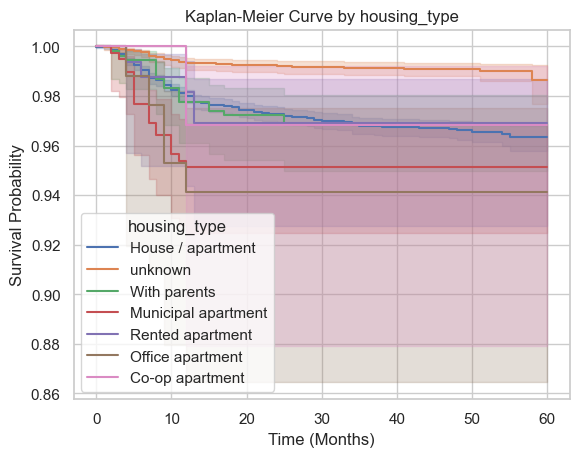

Plotting KM curve for: mobile_flag


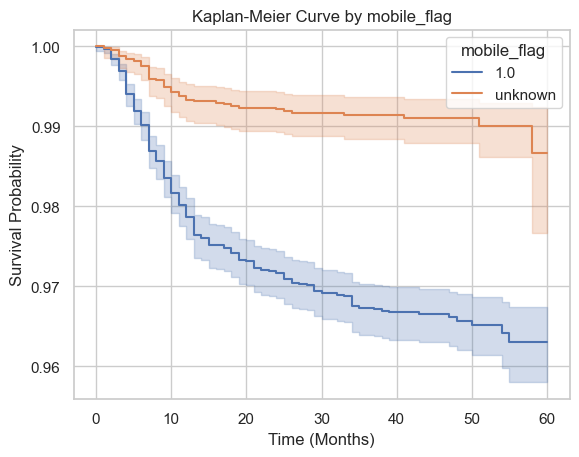

Plotting KM curve for: work_phone


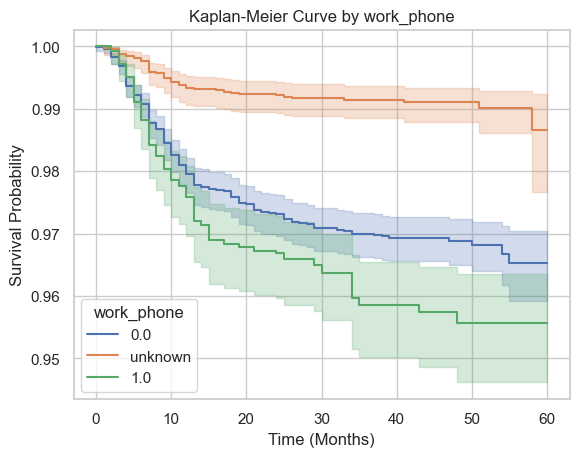

Plotting KM curve for: phone


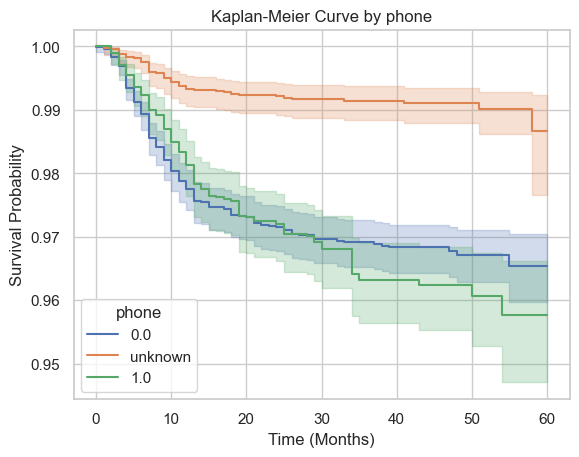

Plotting KM curve for: email_flag


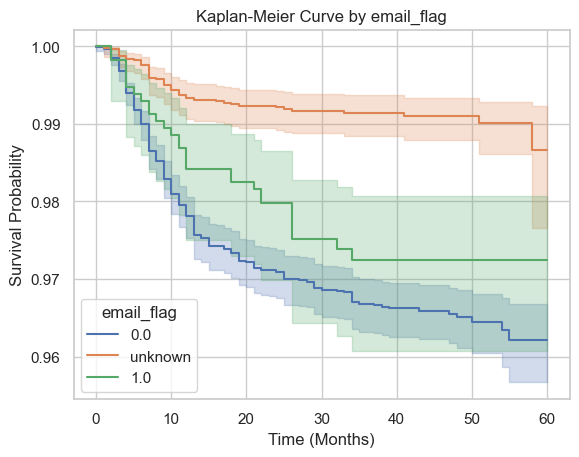

Plotting KM curve for: occupation


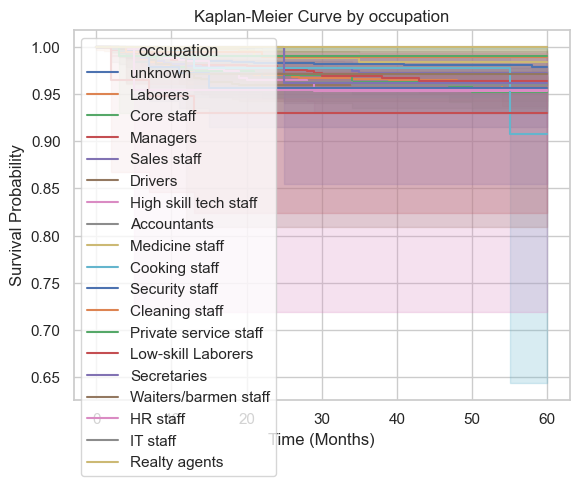

Plotting KM curve for: num_family_members


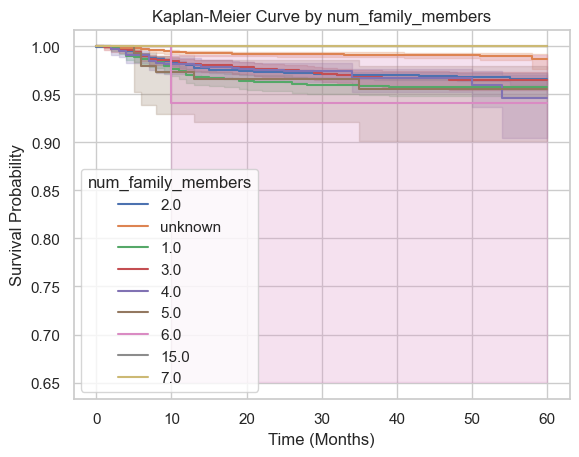

In [69]:
for feature in application_survival_features:
    print(f"Plotting KM curve for: {feature}")
    plot_km(dt, 'month_on_book', 'truncate', feature)